<a href="https://colab.research.google.com/github/Allen001822480/Info7374SpringTeam5/blob/Assignment3/Assignment3_glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
jsonfile = open('Team5_Microsoft.json')
jsondata = jsonfile.read()
textdata = json.loads(jsondata)
#print(textdata)
text = list(textdata['text'].values())
label = list(textdata['sentiment'].values())
  
print(text)
print(label)

['Greetings and welcome to the Microsoft Fiscal Year 2018 Third Quarter Earnings Conference Call. As a reminder, this conference is being recorded. It is now my pleasure to introduce your host, Mike Spencer, General Manager of Investor Relations. Thank you. You may begin.', 'Good afternoon and thank you for joining us today. On the call with me are Satya Nadella, Chief Executive Officer; Amy Hood, Chief Financial Officer; Frank Brod, Chief Accounting Officer; and Carolyn Frantz, Deputy General Counsel and Corporate Secretary.', "On the Microsoft Investor Relations website, you can find our earnings press release and financial summary slide deck, which is intended to supplement our prepared remarks during today's call and provides a reconciliation of differences between the GAAP and non-GAAP financial measures.", "Unless otherwise specified, we refer to non-GAAP metrics on the call. The non-GAAP financial measures provided should not be considered as a substitute for, or superior to, th

In [0]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import numpy as np

maxlen = 200
max_words = 10000
num_classes = 3

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

label = np.asarray(label)
label = keras.utils.to_categorical(label, num_classes)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', label.shape)

x_train,x_test, y_train, y_test = train_test_split(data, label, test_size = 0.2)
print(x_train.shape,x_test.shape)

Using TensorFlow backend.


Found 1689 unique tokens.
Shape of data tensor: (178, 200)
Shape of label tensor: (178, 3)
(142, 200) (36, 200)


In [0]:
import requests
file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
tr = requests.get(file_url, stream=True)
with open("glove.6B.zip", "wb") as f:
    for chunk in tr.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)
            
            
import zipfile
import os
def un_zip(file_name):
    """unzip zip file"""
    zip_file = zipfile.ZipFile(file_name)
    if os.path.isdir(file_name + "_files"):
        pass
    else:
        os.mkdir(file_name + "_files")
    for names in zip_file.namelist():
        zip_file.extract(names,file_name + "_files/")
    zip_file.close()
        
glove = un_zip("glove.6B.zip")

In [0]:
import numpy as np
glove_dir = './glove.6B.zip_files'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 99        
Total params: 1,640,131
Trainable params: 1,640,131
Non-trainable params: 0
_________________________________________________________________


Train on 142 samples, validate on 36 samples
Epoch 1/15
142/142 [==============================] - 1s 5ms/step - loss: 1.6410 - acc: 0.5352 - val_loss: 0.7219 - val_acc: 0.7222
Epoch 2/15
142/142 [==============================] - 0s 480us/step - loss: 0.4594 - acc: 0.8521 - val_loss: 0.6982 - val_acc: 0.7778
Epoch 3/15
142/142 [==============================] - 0s 470us/step - loss: 0.2896 - acc: 0.9225 - val_loss: 0.6777 - val_acc: 0.7778
Epoch 4/15
142/142 [==============================] - 0s 439us/step - loss: 0.1933 - acc: 0.9507 - val_loss: 0.7413 - val_acc: 0.7500
Epoch 5/15
142/142 [==============================] - 0s 473us/step - loss: 0.1449 - acc: 0.9648 - val_loss: 0.8011 - val_acc: 0.7778
Epoch 6/15
142/142 [==============================] - 0s 452us/step - loss: 0.1207 - acc: 0.9507 - val_loss: 0.5910 - val_acc: 0.7778
Epoch 7/15
142/142 [==============================] - 0s 455us/step - loss: 0.0826 - acc: 0.9789 - val_loss: 0.6141 - val_acc: 0.7500
Epoch 8/15
142/142 

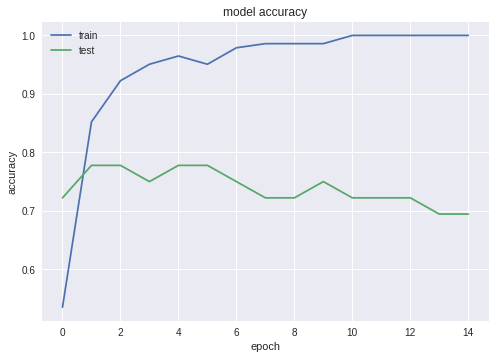

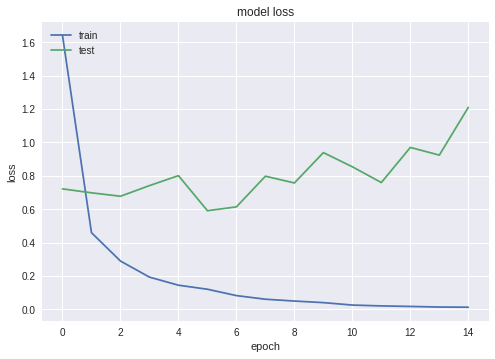

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_data=(x_test, y_test))
model.save_weights('microsoftQ4_glove.h5')

import matplotlib.pyplot as plt

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
flatten_8 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                640032    
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 99        
Total params: 1,640,131
Trainable params: 1,640,131
Non-trainable params: 0
_________________________________________________________________


Train on 142 samples, validate on 36 samples
Epoch 1/10
142/142 [==============================] - 1s 7ms/step - loss: 0.2385 - acc: 0.9085 - val_loss: 1.2583 - val_acc: 0.7222
Epoch 2/10
142/142 [==============================] - 0s 499us/step - loss: 0.0984 - acc: 0.9648 - val_loss: 1.0495 - val_acc: 0.7500
Epoch 3/10
142/142 [==============================] - 0s 473us/step - loss: 0.0732 - acc: 0.9859 - val_loss: 1.6083 - val_acc: 0.7222
Epoch 4/10
142/142 [==============================] - 0s 473us/step - loss: 0.1025 - acc: 0.9577 - val_loss: 1.3784 - val_acc: 0.7222
Epoch 5/10
142/142 [==============================] - 0s 478us/step - loss: 0.0958 - acc: 0.9648 - val_loss: 1.4491 - val_acc: 0.6944
Epoch 6/10
142/142 [==============================] - 0s 473us/step - loss: 0.0669 - acc: 0.9718 - val_loss: 1.0021 - val_acc: 0.6944
Epoch 7/10
142/142 [==============================] - 0s 494us/step - loss: 0.1012 - acc: 0.9718 - val_loss: 1.8083 - val_acc: 0.6944
Epoch 8/10
142/142 

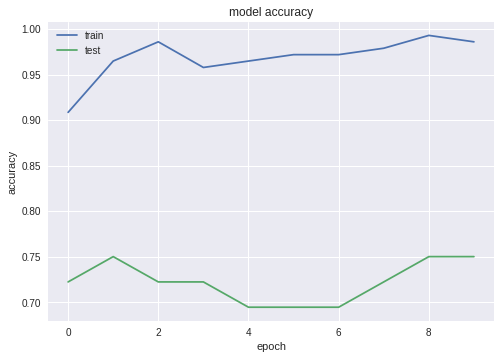

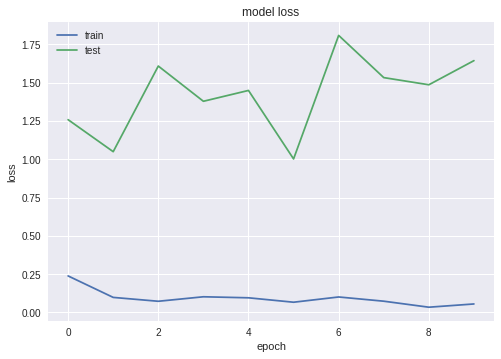

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test, y_test))
model.save_weights('microsoftQ4_glove.h5')

import matplotlib.pyplot as plt

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
import requests
file_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
tr = requests.get(file_url, stream=True)
with open("aclImdb_v1.tar.gz", "wb") as f:
    for chunk in tr.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)

In [0]:
import gzip
import os
def un_gz(file_name):
    f_name = file_name.replace(".gz", "")
    g_file = gzip.GzipFile(file_name)
    open(f_name, "wb+").write(g_file.read())
    g_file.close()

import tarfile
def un_tar(file_name):
    tar = tarfile.open(file_name)
    names = tar.getnames()
    if os.path.isdir(file_name + "_files"):
        pass
    else:
        os.mkdir(file_name + "_files")
    for name in names:
        tar.extract(name, file_name + "_files/")
    tar.close()
    
un_gz("aclImdb_v1.tar.gz")
un_tar("aclImdb_v1.tar")

In [0]:
import os

imdb_dir = '/content/aclImdb_v1.tar_files/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

imbd_labels = []
imbd_texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            imbd_texts.append(f.read())
            f.close()
            if label_type == 'neg':
                imbd_labels.append(0)
            else:
                imbd_labels.append(1)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

maxlen = 200  
max_words = 10000 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(imbd_texts)
sequences = tokenizer.texts_to_sequences(imbd_texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(imbd_labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

x_train,x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2)
print(x_train.shape,x_test.shape)

Found 88582 unique tokens.
Shape of data tensor: (25000, 200)
Shape of label tensor: (25000,)
(20000, 200) (5000, 200)


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,640,065
Trainable params: 1,640,065
Non-trainable params: 0
_________________________________________________________________


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 182us/step - loss: 0.1336 - acc: 0.9432 - val_loss: 1.3399 - val_acc: 0.5814
Epoch 2/10
20000/20000 [==============================] - 3s 173us/step - loss: 0.1039 - acc: 0.9565 - val_loss: 2.1730 - val_acc: 0.5768
Epoch 3/10
20000/20000 [==============================] - 3s 169us/step - loss: 0.0792 - acc: 0.9674 - val_loss: 1.8444 - val_acc: 0.5868
Epoch 4/10
20000/20000 [==============================] - 3s 166us/step - loss: 0.0717 - acc: 0.9696 - val_loss: 2.0286 - val_acc: 0.5818
Epoch 5/10
20000/20000 [==============================] - 3s 167us/step - loss: 0.0574 - acc: 0.9759 - val_loss: 2.2884 - val_acc: 0.5812
Epoch 6/10
20000/20000 [==============================] - 4s 185us/step - loss: 0.0538 - acc: 0.9770 - val_loss: 3.1441 - val_acc: 0.5626
Epoch 7/10
20000/20000 [==============================] - 4s 177us/step - loss: 0.0411 - acc: 0.9819 - val_loss: 2.3200 - v

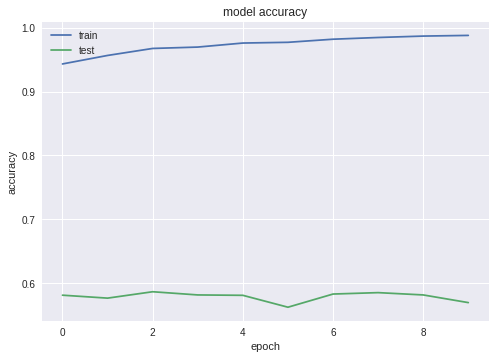

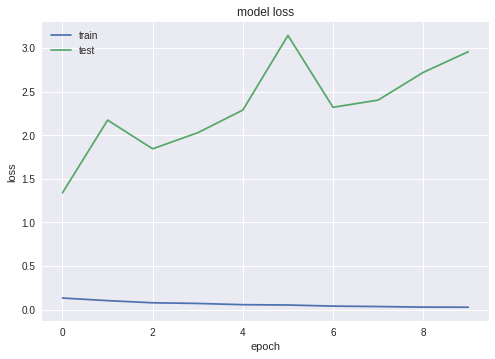

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test, y_test))
model.save_weights('imbd_glove.h5')

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



(5000,)
[0. 1. 1. ... 1. 1. 0.]
(5000,)
[0 1 1 ... 1 1 0]


<Figure size 576x396 with 0 Axes>

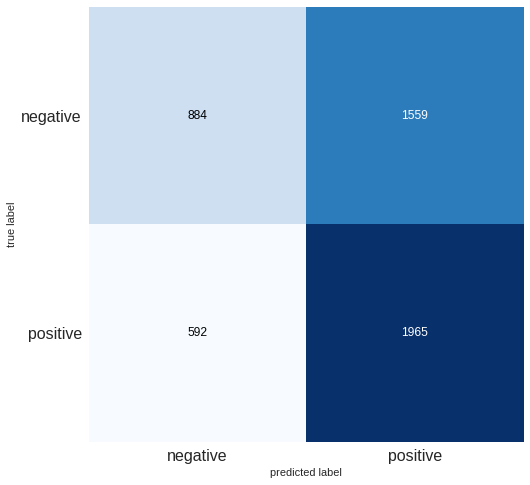

In [0]:
preds = model.predict(x_test, batch_size=16)
preds = preds.flatten()
preds = list(map(round,preds))
preds = np.asarray(preds)
print(preds.shape)
print(preds)
print(y_test.shape)
print(y_test)

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm=confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['negative','positive'], fontsize=16)
plt.yticks(range(2), ['negative','positive'], fontsize=16)
plt.show()

In [0]:
import json
jsonfile = open('Team5_Microsoft.json')
jsondata = jsonfile.read()
textdata = json.loads(jsondata)
#print(textdata)
text = list(textdata['text'].values())
label = list(textdata['sentiment'].values())
  
print(text)
print(label)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import numpy as np

maxlen = 200
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

label = np.asarray(label)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', label.shape)


['Greetings and welcome to the Microsoft Fiscal Year 2018 Third Quarter Earnings Conference Call. As a reminder, this conference is being recorded. It is now my pleasure to introduce your host, Mike Spencer, General Manager of Investor Relations. Thank you. You may begin.', 'Good afternoon and thank you for joining us today. On the call with me are Satya Nadella, Chief Executive Officer; Amy Hood, Chief Financial Officer; Frank Brod, Chief Accounting Officer; and Carolyn Frantz, Deputy General Counsel and Corporate Secretary.', "On the Microsoft Investor Relations website, you can find our earnings press release and financial summary slide deck, which is intended to supplement our prepared remarks during today's call and provides a reconciliation of differences between the GAAP and non-GAAP financial measures.", "Unless otherwise specified, we refer to non-GAAP metrics on the call. The non-GAAP financial measures provided should not be considered as a substitute for, or superior to, th

(178,)
[1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 0. 0.]


<Figure size 576x396 with 0 Axes>

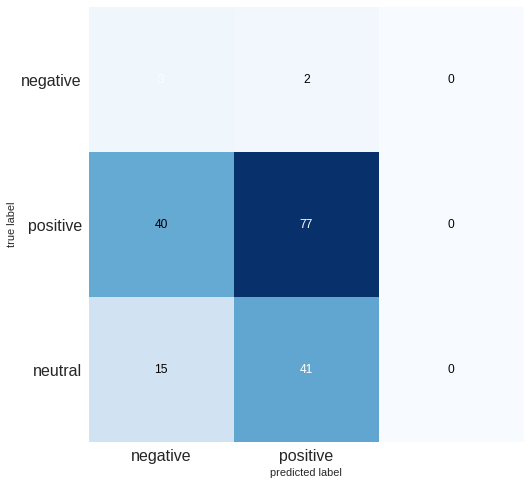

In [0]:
preds_finan = model.predict(data, batch_size=16)
preds_finan = preds_finan.flatten()
preds_finan = list(map(round,preds_finan))
preds_finan = np.asarray(preds_finan)
print(preds_finan.shape)
print(preds_finan)

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm=confusion_matrix(label, preds_finan)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['negative','positive'], fontsize=16)
plt.yticks(range(3), ['negative','positive','neutral'], fontsize=16)
plt.show()

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                320016    
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 1,320,033
Trainable params: 1,320,033
Non-trainable params: 0
_________________________________________________________________


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 178us/step - loss: 0.7024 - acc: 0.5009 - val_loss: 0.6933 - val_acc: 0.4912
Epoch 2/10
20000/20000 [==============================] - 3s 161us/step - loss: 0.6948 - acc: 0.4991 - val_loss: 0.6941 - val_acc: 0.4924
Epoch 3/10
20000/20000 [==============================] - 3s 158us/step - loss: 0.6944 - acc: 0.5054 - val_loss: 0.6940 - val_acc: 0.4960
Epoch 4/10
20000/20000 [==============================] - 3s 163us/step - loss: 0.6926 - acc: 0.5104 - val_loss: 0.6942 - val_acc: 0.5022
Epoch 5/10
20000/20000 [==============================] - 3s 158us/step - loss: 0.6916 - acc: 0.5182 - val_loss: 0.6961 - val_acc: 0.5028
Epoch 6/10
20000/20000 [==============================] - 3s 159us/step - loss: 0.6854 - acc: 0.5243 - val_loss: 0.6972 - val_acc: 0.5052
Epoch 7/10
20000/20000 [==============================] - 3s 161us/step - loss: 0.6819 - acc: 0.5373 - val_loss: 0.7005 - v

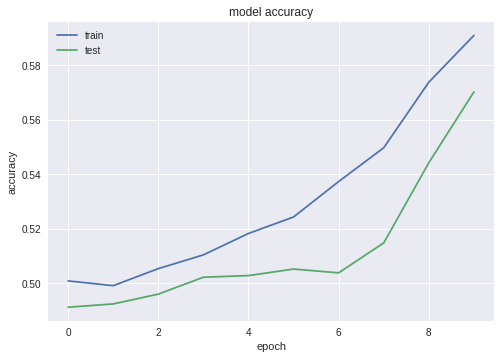

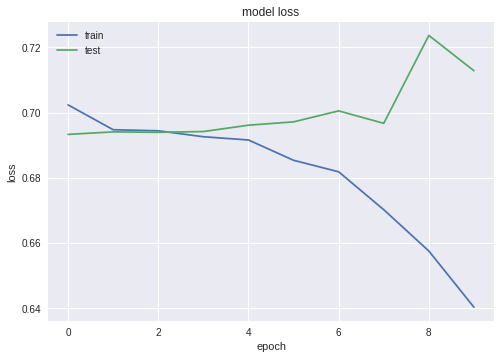

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test, y_test))
model.save_weights('imbd_glove.h5')

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



(5000,)
[0. 0. 0. ... 0. 1. 1.]
(5000,)
[1 0 1 ... 1 0 1]


<Figure size 576x396 with 0 Axes>

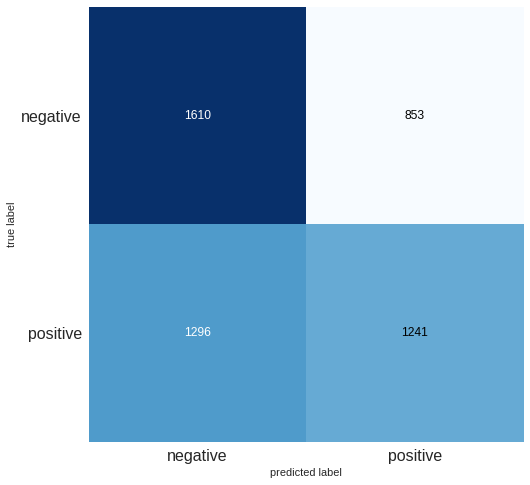

In [0]:
preds = model.predict(x_test, batch_size=16)
preds = preds.flatten()
preds = list(map(round,preds))
preds = np.asarray(preds)
print(preds.shape)
print(preds)
print(y_test.shape)
print(y_test)

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm=confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['negative','positive'], fontsize=16)
plt.yticks(range(2), ['negative','positive'], fontsize=16)
plt.show()

(178,)
[1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]


<Figure size 576x396 with 0 Axes>

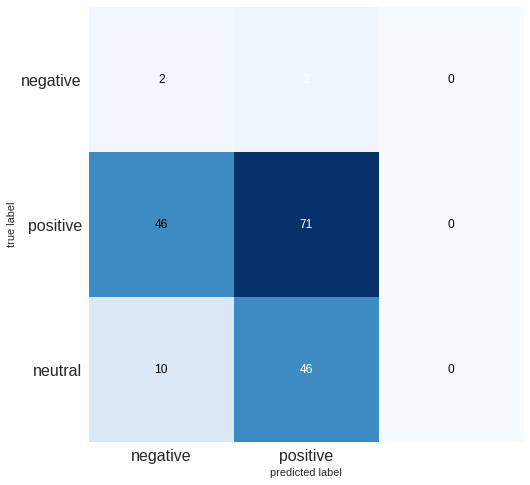

In [0]:
preds_finan = model.predict(data, batch_size=16)
preds_finan = preds_finan.flatten()
preds_finan = list(map(round,preds_finan))
preds_finan = np.asarray(preds_finan)
print(preds_finan.shape)
print(preds_finan)

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm=confusion_matrix(label, preds_finan)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['negative','positive'], fontsize=16)
plt.yticks(range(3), ['negative','positive','neutral'], fontsize=16)
plt.show()